Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from scipy import stats


Load dataset

In [4]:
df = pd.read_csv('/Creditcard_data.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Check imbalance

In [5]:
print(df['Class'].value_counts())


Class
0    763
1      9
Name: count, dtype: int64


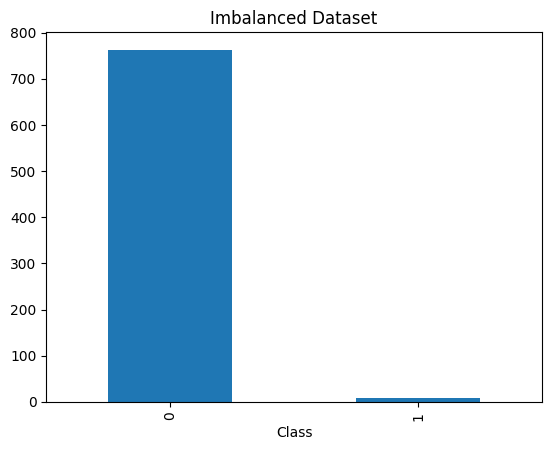

In [6]:
df['Class'].value_counts().plot(kind='bar', title='Imbalanced Dataset')
plt.show()


Separate majority & minority class

In [7]:
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

print("Fraud:", len(fraud))
print("Non Fraud:", len(non_fraud))


Fraud: 9
Non Fraud: 763


BALANCING (Undersampling + Oversampling)

Undersampling

In [8]:
non_fraud_sample = non_fraud.sample(n=len(fraud), random_state=42)
undersampled_df = pd.concat([fraud, non_fraud_sample])


Oversampling

In [9]:
fraud_oversample = fraud.sample(n=len(non_fraud), replace=True, random_state=42)
oversampled_df = pd.concat([non_fraud, fraud_oversample])


Create balanced dataset

In [10]:
balanced_df = oversampled_df.sample(frac=1, random_state=42)  # shuffle
balanced_df['Class'].value_counts()


,count
Class,
1,763
0,763


Create 5 samples

In [11]:
sample1 = balanced_df.sample(frac=0.2, random_state=1)   # Simple random
sample2 = balanced_df.sample(frac=0.2, random_state=2)   # Systematic-like
sample3 = balanced_df.groupby('Class').sample(frac=0.2)  # Stratified
sample4 = balanced_df.sample(frac=0.2, random_state=4)   # Cluster-like
sample5 = balanced_df.sample(frac=0.2, replace=True)     # Bootstrap


GOODNESS OF SAMPLE

In [12]:
def check_goodness_of_sample(sample):
    values = sample['Amount']

    print("Mean:", np.mean(values))
    print("Median:", np.median(values))
    print("Variance:", np.var(values))
    print("Std Dev:", np.std(values))
    print("Skewness:", stats.skew(values))
    print("Kurtosis:", stats.kurtosis(values))


Prepare models (M1–M5)

In [13]:
models = {
    "M1_Logistic": LogisticRegression(max_iter=1000),
    "M2_DecisionTree": DecisionTreeClassifier(),
    "M3_RandomForest": RandomForestClassifier(),
    "M4_KNN": KNeighborsClassifier(),
    "M5_SVM": SVC()
}


Function to train & get accuracy

In [14]:
def train_model(sample, model):
    X = sample.drop('Class', axis=1)
    y = sample['Class']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)


Apply all sampling on all models

In [15]:
samples = [sample1, sample2, sample3, sample4, sample5]
results = []

for mname, model in models.items():
    row = [mname]
    for s in samples:
        acc = train_model(s, model)
        row.append(round(acc * 100, 2))
    results.append(row)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Create final table (matches teacher format)

In [16]:
result_df = pd.DataFrame(
    results,
    columns=['Model', 'Sampling1', 'Sampling2', 'Sampling3', 'Sampling4', 'Sampling5']
)

result_df


,Model,Sampling1,Sampling2,Sampling3,Sampling4,Sampling5
0,M1_Logistic,88.04,94.57,90.22,91.30,84.78
1,M2_DecisionTree,100.00,97.83,95.65,95.65,98.91
2,M3_RandomForest,100.00,100.00,100.00,100.00,100.00
3,M4_KNN,90.22,90.22,90.22,89.13,91.30
4,M5_SVM,80.43,66.30,55.43,59.78,72.83


Save results

In [17]:
result_df.to_csv('accuracy_results.csv', index=False)
